# Motor Imagery Cassification

In [2]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import json
import mne
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from openbci.preprocess import eeg_filters
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

## Previsualización de los datos de entrada

In [3]:
filename = "2019-07-19 17_41_51.820255"
# filename = "2019-11-18 11_00_30.869375"
# filename = '2019-11-26 14_50_47.191628'

Form previously acquired data in `CSV` format

Input data size: (84318, 17)


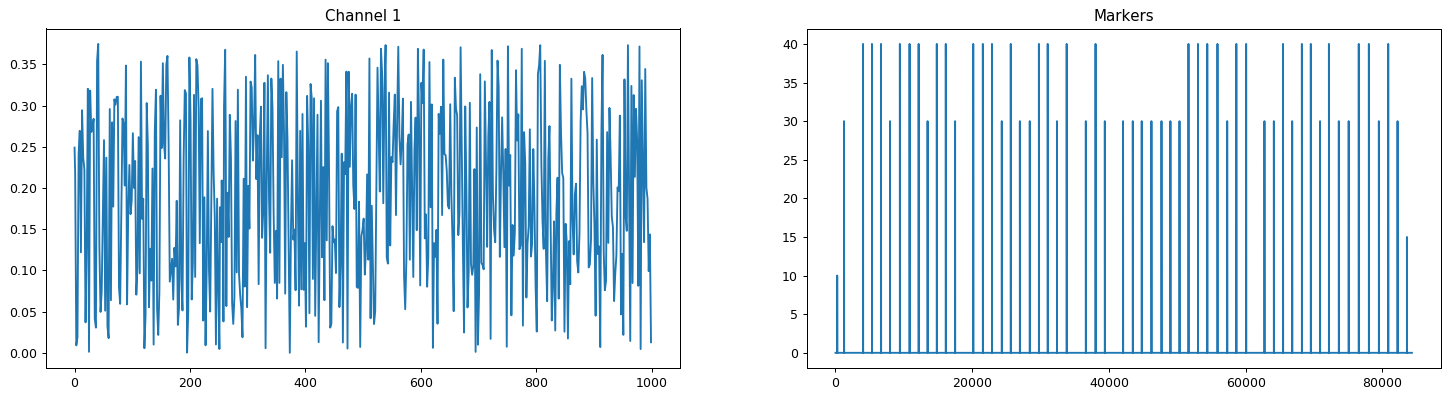

In [4]:
data = np.loadtxt(f"data/{filename}.csv", delimiter=',')
print(f"Input data size: {data.shape}")

plt.figure(figsize=(20, 5), dpi=90)

# Only plot the fist column
plt.subplot(121)
col1 = data[:,0]  
plt.plot(col1[:1000]) 
plt.title("Channel 1")

# and the markers
plt.subplot(122)
markers = data[:,-1]  # the marker are in the last column
plt.plot(markers)
plt.title("Markers")

plt.show()

The acquisition generate to a `JSON` file with the information of the trials, channels, etc.

In [5]:
descriptor = json.load(open(f"data/{filename}.json", 'r'))
descriptor

{'datetime': '2019-07-19 17:41:51.820255',
 'sample_rate': '249.6 Hz',
 'channels': 'Fp1, Fp2, F7, Fz, F8, C3, Cz, C4, T5, P3, Pz, P4, T6, O1, Oz, O2',
 'channels_system': '10-20',
 'start_marker': 10,
 'end_marker': 15,
 'right_marker': 30,
 'left_marker': 40,
 'stimulus_end_marker': 5}

With this data, we can create a full visualization of the entire acquisition

Sample rate: 249.6
Channels: ['Fp1', 'Fp2', 'F7', 'Fz', 'F8', 'C3', 'Cz', 'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'Oz', 'O2']
----------------------------------------------------------------------
Start marker position: [253]
Right marker positions: [ 1257  7966 13471 17497 24323 26967 28416 32396 36615 39394 42066 43486
 44793 46216 47685 48992 50319 57297 62745 64120 66802 70878 73622 75066
 79479 82213]
----------------------------------------------------------------------


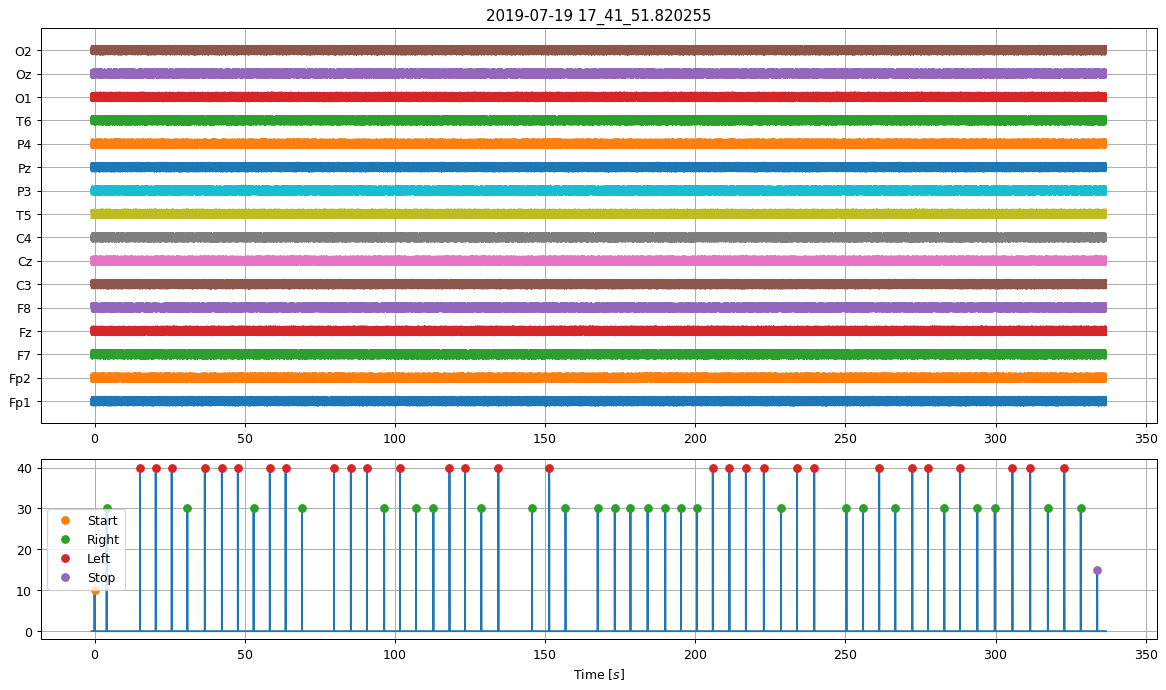

In [6]:
# format the descriptor
sample_rate = float(descriptor['sample_rate'].replace(' Hz', ''))
start_marker = descriptor['start_marker']
stop_marker = descriptor['end_marker']
left_marker = descriptor['left_marker']
right_marker = descriptor['right_marker']
channels_names = descriptor['channels'].split(',')
channels_names = [ch.upper().strip().capitalize() for ch in channels_names]

print(f"Sample rate: {sample_rate}")
print(f"Channels: {channels_names}")
print("-"*70)

# Markers positions
start = (np.where(data[:, -1] == start_marker)[0])
stop = (np.where(data[:, -1] == stop_marker)[0])
right = (np.where(data[:, -1] == right_marker)[0])
left = (np.where(data[:, -1] == left_marker)[0])

print(f"Start marker position: {start}")
print(f"Right marker positions: {right}")
print("-"*70)

# vector time from sample rate
time = np.linspace(0, data.shape[0] / sample_rate, data.shape[0]) - start / sample_rate

fig = plt.figure(figsize=(16, 9), dpi=90)
gridsize = (3, 1) 


## EEG plot
ax1 = plt.subplot2grid(gridsize, (0, 0), rowspan=2)
plt.title(filename)

# replace the y ticks with the channels names 
ax1.set_yticks(range(0, len(channels_names)))
ax1.set_yticklabels(channels_names)

[plt.plot(time, d[0] - np.mean(d[1]) + d[1]) for d in enumerate(data[:, :-1].T)]
plt.grid(True)



# Markers plot
ax2 = plt.subplot2grid(gridsize, (2, 0))
plt.plot(time, data[:, -1])
plt.grid(True)

# markers legends
plt.plot(time[start], data[:, -1][start], 'o', label='Start')
plt.plot(time[right], data[:, -1][right], 'o', label='Right')
plt.plot(time[left], data[:, -1][left], 'o', label='Left')
plt.plot(time[stop], data[:, -1][stop], 'o', label='Stop')
plt.legend()

plt.xlabel('Time [$s$]')
plt.show()

## Using MNE for topoplots

In [1]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(channels_names, sfreq=sample_rate, ch_types="eeg", montage=montage)

# first 'column' of eeg
values = data[:,:-1][0]

plt.figure(figsize=(5, 5), dpi=90)
mne.viz.plot_topomap(values, info, names=channels_names, show_names=True)
plt.show()
channels_names

NameError: name 'mne' is not defined

## Filtering and data partition

From EEG `data` extract the number `width` of data after each `marker_name` occurrence.

In [82]:
def get_markers(data, marker_name, width, offset=0):
    
    eeg_data = data[:,:-1]
    markers = data[:,-1]
    
    # filtering with openbci
    eeg_data = eeg_filters.band330(eeg_data)
    eeg_data = eeg_data**2
    
    # data centralization
    eeg_data = eeg_data - eeg_data.mean(axis=0)
    
    marker = descriptor[marker_name]
    index = np.argwhere(markers == marker).reshape(-1)
    
    print(f"Index for {marker_name}: {index}")
    return [eeg_data[start+offset:start+width].copy() for start in index]

In [83]:
O = 0.4
offset = int(sample_rate*O)

W =  1
width = int(sample_rate*W)  # the first N seconds

rights = get_markers(data, 'right_marker', width, offset)
lefts = get_markers(data, 'left_marker', width, offset)

print('-'*70)
print(f"{len(rights)} right markers")
print(f"{len(lefts)} left markers")

Index for right_marker: [ 1257  7966 13471 17497 24323 26967 28416 32396 36615 39394 42066 43486
 44793 46216 47685 48992 50319 57297 62745 64120 66802 70878 73622 75066
 79479 82213]
Index for left_marker: [ 4035  5336  6664  9416 10835 12162 14818 16132 20151 21553 22891 25637
 29752 31042 33817 38040 51634 53018 54383 55875 58633 60069 65466 68218
 69525 72173 76539 78016 80850]
----------------------------------------------------------------------
26 right markers
29 left markers


## Secuential topoplots

In [84]:
def historical(data, N, name=""):
    
    # how N topoplots for trial 
    fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(30, 8), dpi=90)
    for i, d in enumerate(np.linspace(0, len(data)-1, N)):
        values = data.copy()[int(d)]
        mne.viz.plot_topomap(values, info, axes=axes[i], show=False)
    
    # time as title
    for i, t in enumerate(np.linspace(O, W, N)):
        axes[i].set_title(f"{t:.02}s")
    
    if name:
        axes[0].set_ylabel(name)

    plt.show() 

`ipywidgets` requiered : https://ipywidgets.readthedocs.io/en/latest/user_install.html  

In [85]:
@interact(event=range(len(rights)))
def show_frame(event=0):
    historical(rights[event], N=12, name="Right")

interactive(children=(Dropdown(description='event', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [86]:
@interact(event=range(len(lefts)))
def show_frame(event=0):
    historical(lefts[event], N=12, name="Left")

interactive(children=(Dropdown(description='event', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [87]:
# historical(rights[0], N=12, name="Right")
# historical(lefts[0], N=12, name="Left")

## Simple classification

In [88]:
# Split input and outputs
Xraw = np.concatenate((rights, lefts))
Xraw = np.array([x.T for x in Xraw])

y = np.array([1]*len(rights) + [-1]*len(lefts))  # 1:derecha y -1:izquierda

print(f"Input: {Xraw.shape}")
print(f"Output: {y.shape}")

Input: (55, 16, 150)
Output: (55,)


Computing data rank from raw with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 16 dim * 3.7e+11  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 16 dim * 3.5e+11  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


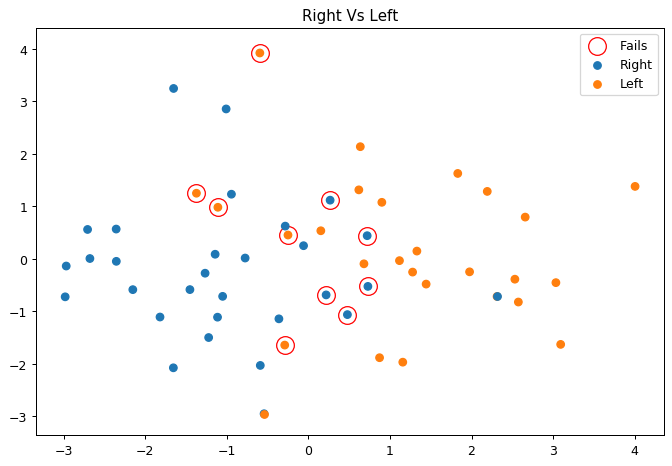

In [177]:
csp_epochs = CSP(n_components=8, reg='empirical', log=True, norm_trace=False, transform_into='average_power')
csp_epochs.fit(Xraw, y)

scaler = StandardScaler()
Xcsp = csp_epochs.transform(Xraw)
Xdataz = scaler.fit_transform(Xcsp)
pca = PCA(n_components=2)
Z = pca.fit_transform(Xdataz)

fig = plt.figure(figsize=(9, 6), dpi=90)
plt.title("Right Vs Left")

yc = ["C0" if (i == -1) else 'C1' for i in y]
plt.scatter(*Z.T, c=yc, zorder=1)

s = np.append(Z, y.reshape(y.shape[0], 1), axis=1)
Zf = Z[np.sign(s[:,0]) != np.sign(s[:,2])]
plt.scatter(*Zf.T, marker='o', c='w', s=200, edgecolors='red', zorder=0, label='Fails')

plt.scatter(*Z[0], c="C0", label='Right')
plt.scatter(*Z[-1], c="C1", label='Left')
plt.legend()

plt.show()